In [1]:
from weasyprint import HTML, CSS
from weasyprint.fonts import FontConfiguration
import matplotlib.pyplot as plt
import cv2
import numpy as np
from cairocffi import FORMAT_ARGB32
from jinja2 import Environment, FileSystemLoader, select_autoescape
from weasyprint import HTML
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image, ImageDraw as D

from datasets import load_dataset
import fuzzysearch

from typing import List, Tuple, Dict, Union, Optional
import numpy as np
import copy
import wandb
import pandas as pd
from pprint import pprint
from utils.utils import crop_image, concatenate_images, embed_image

Config:
{'epochs': 100, 'batch_size': 32, 'squad_version': 1, 'html_template': 'pixel_block.html.jinja', 'image_resolution': 92, 'channel': 'GRAYSCALE', 'image_height': 368, 'image_width': 368, 'maximal_white_space_in_image': 68, 'max_seq_length': 529, 'min_paragraph_length': 200, 'font_list_path': 'fonts/clean_fonts_with_size.csv', 'max_snippet_length': 2000, 'mask_block_probability': 0.25, 'mask_block_size': [32, 16], 'mask_max_merged_blocks_size': [2, 6], 'mask_min_merged_blocks_size': [1, 2], 'patch_base_size': [16, 16], 'num_patches': 529}


Found cached dataset squad (/home/knf792/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


Fonts:
[{'file_name': 'fonts/PowellAntique-Bold.ttf',
  'font_name': 'Powellantique-Bold',
  'font_size': 15},
 {'file_name': 'fonts/CaslonAntique-Bold.ttf',
  'font_name': 'Caslonantique-Bold',
  'font_size': 10}]
(368, 368)


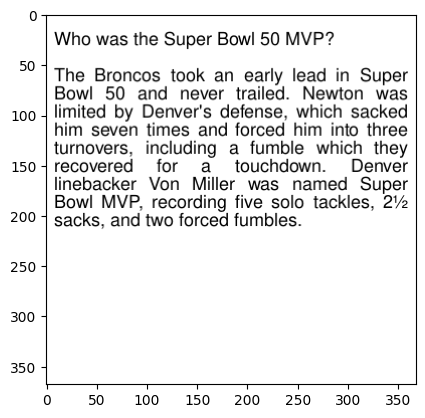

In [6]:
DEFAULT_COMBINATIONS = {
    "language": "en_US",
     "font_family": "Garamond",
     "font_size": "18px",
     "text_align": "justify",
     "hyphenate": False,
     "width": "368px",
     "height": "368px",
     "top_margin": "0px",
     "right_margin": "0px",
     "bottom_margin": "0px",
     "left_margin": "0px",
     "line_spacing": ".5",
     "word_break": None,
     "line_break": None,
     "line_height_question": None,
     "line_height_context": None,
     "line_height_pretraining": None,
}

def get_updated_style_config_squad(custom_fonts):
    """
    A function to get the updated style config from wandb
    """
    style = copy.deepcopy(DEFAULT_COMBINATIONS)
    style["custom_fonts"] = custom_fonts
    style["font_family_question"] = custom_fonts[0]["font_name"]
    style["font_family_context"] = custom_fonts[1]["font_name"]
    style["font_size_question"] = f"{custom_fonts[0]['font_size'] + 2}px"
    style["font_size_context"] = f"{custom_fonts[1]['font_size']}px"
    
    for key in style:
        if key in wandb.config:
            style[key] = [wandb.config[key]]
    return style
    
    
def get_updated_style_config_pretraining(custom_fonts):
    """
    A function to get the updated style config from wandb
    """
    style = copy.deepcopy(DEFAULT_COMBINATIONS)
    style["custom_fonts"] = custom_fonts
    style["font_family_pretraining"] = custom_fonts[0]["font_name"]
    style["font_size_pretraining"] = f"{custom_fonts[0]['font_size']}px"
    
    for key in style:
        if key in wandb.config:
            style[key] = [wandb.config[key]]
    return style

def get_random_custom_fonts(font_list, n=2, seed=42):
    rng = np.random.default_rng(seed)
    random_index = rng.integers(0, font_list.shape[0], n)
    random_fonts = font_list["path"][random_index].tolist()
    font_sizes = font_list["base_size"][random_index].tolist()
    font_sizes = [int(size / 2) + rng.integers(-4, 5, 1)[0] for size in font_sizes]
    custom_fonts = []
    for font, size in zip(random_fonts, font_sizes):
        font_name = font.split(".")[0].split("/")[1]
        font_dict = {"file_name": font, "font_name": font_name.title(), "font_size": size}
        custom_fonts.append(font_dict)
    return custom_fonts


def generate_html_text_for_squad(template: str, style: Dict, question: str, context: str) -> str:
    env = Environment(loader=FileSystemLoader("./templates/"), 
                  autoescape=select_autoescape(["html", "xml"]))
    template = env.get_template(template)
    html_text = template.render(question=question, context=context, **style)
    return html_text


def generate_html_text_for_pretraining(template: str, style: Dict, pretraining_text: str) -> str:
    env = Environment(loader=FileSystemLoader("./templates/"), 
                  autoescape=select_autoescape(["html", "xml"]))
    template = env.get_template(template)
    html_text = template.render(pretraining_text=pretraining_text, **style)
    return html_text


def render_html_as_image(html_text: str, image_resolution: int = 96, channel: str = 'GRAYSCALE'):
    """
    A function to render an HTML text as an image
    """
    font_config = FontConfiguration()  # TODO define once outside the function
    html=HTML(string=html_text, base_url=".")
    doc = html.render(font_config=font_config)
    surface, width, height = doc.write_image_surface(resolution=image_resolution)
    img_format = surface.get_format()

    # This is BGRA channel in little endian (reverse)
    if img_format != FORMAT_ARGB32:
        raise RuntimeError(
            f"Expect surface format to be 'cairocffi.FORMAT_ARGB32', but got {img_format}." +
            "Please check the underlining implementation of 'weasyprint.document.Document.write_image_surface()'"
        )

    img_buffer = surface.get_data()
    # Returns image array in "BGRA" channel
    img_array = np.ndarray(
        shape=(height, width, 4), dtype=np.uint8, buffer=img_buffer
    )
    if channel == "GRAYSCALE":
            return cv2.cvtColor(img_array, cv2.COLOR_BGRA2GRAY)
    elif channel == "RGBA":
        return cv2.cvtColor(img_array, cv2.COLOR_BGRA2RGBA)
    elif channel == "RGB":
        return cv2.cvtColor(img_array, cv2.COLOR_BGRA2RGB)
    elif channel == "BGRA":
        return np.copy(img_array)
    elif channel == "BGR":
        return cv2.cvtColor(img_array, cv2.COLOR_BGRA2BGR)
    else:
        valid_channels = ["GRAYSCALE", "RGB", "RGBA", "BGR", "BGRA"]
        raise ValueError(
            f"Invalid channel code {channel}. Valid values are: {valid_channels}."
        )  
            

def construct_image_from_squad_instance(instance: Dict,
                                        style: Dict,
                                        image_resolution: int = 96,
                                        channel: str = 'GRAYSCALE',
                                        template: str = "pixel_block.html.jinja",
                                        template_path: Optional[str] = None) -> np.ndarray:
    """
    A function to construct an image from a SQuAD instance, given a pattern and a style
    :param instance: A SQuAD instance
    :param pattern: A pattern to construct the content of the image
    :param style: A style to construct the image
    :param image_resolution: The resolution of the image
    :param channel: The channel of the image, either 'GRAYSCALE' or 'RGB' or 'RGBA'
    """
    question = instance['question']
    context = instance['context']
    html_text = generate_html_text_for_squad(template, style, question, context)
    img_array = render_html_as_image(html_text, image_resolution, channel)
    return img_array
    
    
def construct_image_from_pretrained_text(instance: str,
                                         style: Dict,
                                         image_resolution: int = 96,
                                         channel: str = 'GRAYSCALE',
                                         template: str = "pretraining_block.html.jinja",
                                         template_path: Optional[str] = None) -> np.ndarray:
    """
    A function to construct an image from a pertraining text, given a pattern and a style
    :param instance: A pretraining text instance
    :param pattern: A pattern to construct the content of the image
    :param style: A style to construct the image
    :param image_resolution: The resolution of the image
    :param channel: The channel of the image, either 'GRAYSCALE' or 'RGB' or 'RGBA'
    :param template: The template to use for rendering the image
    :param template_path: The path to the template
    :return: An image array
    """
    html_text = generate_html_text_for_pretraining(template, style, instance)
    img_array = render_html_as_image(html_text, image_resolution, channel)
    return img_array
    

def merge_images(images: List[np.ndarray], axis: int = 0) -> np.ndarray:
    """
    A function to merge images along an axis
    :param images: A list of images
    :param axis: The axis to merge the images along
    :return: A merged image
    """
    cropped_images = [crop_image(image) for image in images]
    concatenated_images = concatenate_images(cropped_images, axis=axis, max_height=368)
    return concatenated_images


# def break_pretaining_text_into_parts(pretraining_text, parts, allow_empty=True) -> List[str]:
#     total_length = len(pretraining_text)
#     parts = []
#     for i in range


# def generate_mixed_style_scan_for_pretraining(pretraining_text: str, num_styles: int=2) -> np.ndarray:
#     """
#     A function to generate a mixed style scan for pretraining
#     :param pretraining_text: The pretraining text
#     :param num_styles: The number of styles to use
#     :return: A mixed style scan
#     """
#     pretraining_text_list = break_pretaining_text_into_parts(pretraining_text, parts=num_styles, allow_empty=True)
#     styles = get_random_styles(num_styles)
#     raw_images = [construct_image_from_pretrained_text(text, style) for text, style in zip(pretraining_text_list, styles)]
#     merged_image = merge_images(raw_images, axis=0)
#     merged_image = embed_image(merged_image)
#     return merged_image


def main():
    wandb.init(config="config.yaml", mode="disabled")
    print("Config:")
    pprint(wandb.config)

    
    squad = load_dataset('squad', split='validation') if wandb.config.squad_version == 1 else load_dataset('squad_v2', split='validation')
    font_list = pd.read_csv("fonts/antique_fonts.csv")
    custom_fonts = get_random_custom_fonts(font_list, seed=44)
    print("Fonts:")
    pprint(custom_fonts)
    
    style = get_updated_style_config_squad(custom_fonts=custom_fonts)
    template = wandb.config.html_template
    image = construct_image_from_squad_instance(squad[55], style, template=template)
    print(image.shape)
    
    plt.imshow(image, cmap='gray')
    image = Image.fromarray(image)
    image.save("test.png")
    return image


image = main()

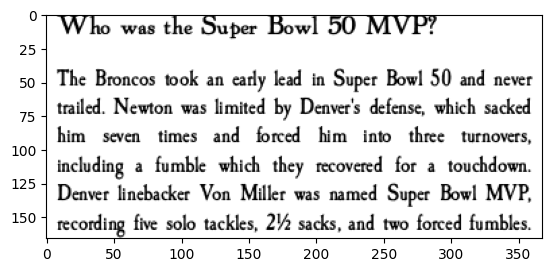

In [14]:

im = crop_image(np.asarray(image))
plt.imshow(im, cmap='gray')